In [ ]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# optimizador de la red por medio de Bayessian Optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Check tensorflow version
print(tf.__version__)

2.11.0


In [ ]:
# Abrimos nuestros dataset para prepararlo
df_train = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/train_data.csv', sep=';', decimal='.')
print(df_train.shape)

df_test = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/test_data.csv', sep=';', decimal='.')
print(df_test.shape)

# Vamos a abrir las imágenes
trainImagesX = np.load("./drive/MyDrive/deep-learning-rogelio/trainImagesX.npy")
print(trainImagesX.shape)

# Abrimos las imagenes de test
testImagesX = np.load("./drive/MyDrive/deep-learning-rogelio/testImagesX.npy")
print(testImagesX.shape)


(750, 22)
(250, 22)
(750, 224, 224, 3)
(250, 224, 224, 3)


In [ ]:
for image in trainImagesX:
    if image.shape >= (224, 224, 4):
        print(image.shape)
        plt.imshow(image)
        plt.show()

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
## Escalamos las imagenes
#scaler = MinMaxScaler()
#x_train_images = scaler.fit_transform(trainImagesX)
#x_test_images = scaler.fit_transform(testImagesX)

In [ ]:
x_train_images = trainImagesX / 255
x_test_images = testImagesX / 255

In [ ]:
# Hacemos el split de train y test para las imágenes y los atributos
# Lo hacemos con el dataframe completo, aún no separamos los valores

split = train_test_split(df_train, x_train_images, test_size=0.1, random_state=42)
(trainAttrX, valAttrX, trainImagesX, valImagesX) = split

In [ ]:
# Separamos x_train, y_train y convertimos a numpy
x_train = trainAttrX.drop(['Price'], axis=1).values
y_train = trainAttrX['Price'].values

x_val = valAttrX.drop(['Price'], axis=1).values
y_val = valAttrX['Price'].values

# Separamos x_test, y_test y convertimos a numpy
x_test = df_test.drop(['Price'], axis=1).values
y_test = df_test['Price'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(x_train)

# Transform the training and test data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
# x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

### Aquí intentamos probar la arquitectura del blog, como una forma diferente de hacer una red convolucional

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras import optimizers, Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import locale
from matplotlib import image as mpimg
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model



def train_deep_net(width, height, depth, filters=(32, 32, 64, 128, 128, 64, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(16)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model


In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 200
INIT_LR = 1e-3
BS = 128

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


model = train_deep_net(width=224, height=224, depth=3, regress=True)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="mse", 
              optimizer=opt, metrics=[metrics.MeanAbsoluteError(), 
                                      metrics.MeanSquaredError(), 
                                      metrics.RootMeanSquaredError(), 
                                      metrics.Accuracy()])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248  

In [ ]:
# train the model
print("[INFO] training model...")
history = model.fit(trainImagesX, y_train,
                    validation_data=(valImagesX, y_val),
                    epochs=EPOCHS,
                    batch_size=BS,
                    callbacks=[early_stopping, reduce_lr])



[INFO] training model...
Epoch 1/200
6/6 [==============================] - 8s 492ms/step - loss: 7484.1489 - mean_absolute_error: 65.6210 - mean_squared_error: 7484.1489 - root_mean_squared_error: 86.5110 - accuracy: 0.0000e+00 - val_loss: 5679.0981 - val_mean_absolute_error: 61.3168 - val_mean_squared_error: 5679.0981 - val_root_mean_squared_error: 75.3598 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 188ms/step - loss: 7416.7139 - mean_absolute_error: 65.2095 - mean_squared_error: 7416.7139 - root_mean_squared_error: 86.1203 - accuracy: 0.0000e+00 - val_loss: 5667.8311 - val_mean_absolute_error: 61.2322 - val_mean_squared_error: 5667.8311 - val_root_mean_squared_error: 75.2850 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 190ms/step - loss: 7384.0874 - mean_absolute_error: 65.0344 - mean_squared_error: 7384.0874 - root_mean_squared_error: 85.9307 - accuracy: 0.0000e+00 - val_loss: 5641.97

In [ ]:
with open('./history.txt', 'w') as f:
  f.write(str(history.history))
!cp history.txt /content/drive/My\ Drive/deep-learning-rogelio/history.txt

In [ ]:
# Evaluamos la red
print("[INFO] evaluating network...")
predictions = model.predict(x_test_images)
diff = predictions.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)


# Evaluamos el performance de la red, vemos si podemos describir todos nuestros datos
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Imprimimos metricas
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)

# Usamos las metricas de medición del blog de sugerencia
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_train["Price"].mean(), grouping=True),
	locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

# Creamos un grid
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])


[INFO] evaluating network...
8/8 [==============================] - 0s 19ms/step
Mean Squared Error (MSE): 5279.0451758053605
Mean Absolute Error (MAE): 60.436313441753384
R-squared (R^2): -2.243576068580607
[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 99.02%, std: 0.61%


<Figure size 864x720 with 0 Axes>

8/8 [==============================] - 0s 19ms/step
[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 99.02%, std: 0.61%


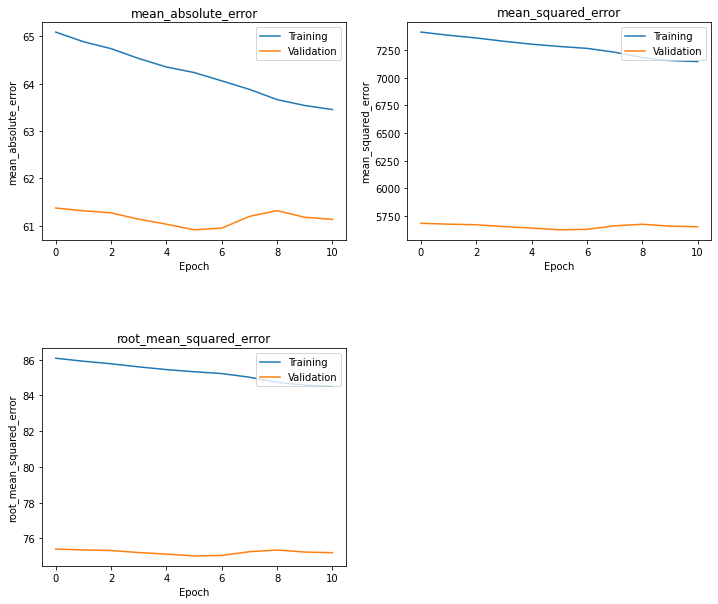

In [ ]:
test_pred = model.predict(x_test_images)
diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

#### DE plano el modelo no pudo converger, vamos a probar con un modelo mas simple